In [1]:
from tensorflow.keras.layers import Input, concatenate, Conv2DTranspose, MaxPooling2D, Conv2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model

In [2]:
def unet(input_size, num_classes):
    input = Input(input_size)

    conv1 = Conv2D(64, 3, padding='same')(input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D((2, 2))(drop4)

    conv5 = Conv2D(1024, 3, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up_conv6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up_conv6 = concatenate([up_conv6, conv4])
    conv6 = Conv2D(512, 3, padding='same')(up_conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    drop6 = Dropout(0.3)(conv6)

    up_conv7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop6)
    up_conv7 = concatenate([up_conv7, conv3])
    conv7 = Conv2D(256, 3, padding='same')(up_conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up_conv8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up_conv8 = concatenate([up_conv8, conv2])
    conv8 = Conv2D(128, 3, padding='same')(up_conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3, padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up_conv9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up_conv9 = concatenate([up_conv9, conv1])
    conv9 = Conv2D(64, 3, padding='same')(up_conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3, padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    output = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=[input], outputs=[output])
    return model

In [3]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import numpy as np
from model import unet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import math

In [4]:
def create_image_pairs(folder_path):
    image_list = sorted(glob(os.path.join(folder_path, "*[!_watershed_mask].bmp")))
    image_list = [img.replace('\\', '/') for img in image_list]
    mask_list = [img.replace('.bmp', '_watershed_mask.bmp') for img in image_list]
    return list(zip(image_list, mask_list))

In [5]:
original_img_pairs = create_image_pairs('C:/IMAGES/dataset/')
augmented_img_pairs = create_image_pairs('C:/IMAGES/dataset_aug/')

all_images = original_img_pairs + augmented_img_pairs

In [6]:
def preprocess_original(path):
    img = cv2.imread(path)
    img = img.astype('float32') / 255.0
    return img

In [7]:
values_to_class_id = {
    11 : 1,
    21 : 2,
    13 : 3,
    12 : 4,
    31 : 5,
    23 : 6,
    24 : 7,
    25 : 8,
    32 : 9,
    22 : 10,
    33 : 11,
    5 : 12
}

In [8]:
def preprocess_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = np.vectorize(lambda x: values_to_class_id.get(x, 0))(mask)
    return tf.keras.utils.to_categorical(mask, num_classes=13).astype('float32')

In [9]:
def data_generator(img_pairs, batch_size):
    while True:
        np.random.shuffle(img_pairs)
        for i in range(0, len(img_pairs), batch_size):
            batch_img_pairs = img_pairs[i : i + batch_size]
            imgs = [preprocess_original(img[0]) for img in batch_img_pairs]
            masks = [preprocess_mask(img[1]) for img in batch_img_pairs]

            yield np.array(imgs), np.array(masks)

In [10]:
train_val_pairs, test_pairs = train_test_split(all_images, test_size=0.1, random_state=42)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.2, random_state=42)

MODEL_BATCH_SIZE = 8

In [11]:
train_gen = data_generator(train_pairs, batch_size=MODEL_BATCH_SIZE)
validation_gen = data_generator(val_pairs, batch_size=MODEL_BATCH_SIZE)

In [12]:
if os.path.exists('unet-model.h5'):
    unet_model = load_model('unet-model.h5')
else:
    unet_model = unet(input_size=(256, 256, 3), num_classes=13)
    unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
checkpoint = ModelCheckpoint('unet-model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, mode='min', verbose=1)

In [14]:
steps_per_epoch = math.ceil(len(train_pairs) / MODEL_BATCH_SIZE)
validation_steps = math.ceil(len(val_pairs) / MODEL_BATCH_SIZE)

unet_model_history = unet_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

unet_model.save('unet-model.h5')

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 0.8786 - accuracy: 0.7019
Epoch 1: val_loss improved from inf to 0.65030, saving model to unet-model.h5
750/750 [==============================] - 516s 660ms/step - loss: 0.8786 - accuracy: 0.7019 - val_loss: 0.6503 - val_accuracy: 0.7763
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.8507
Epoch 2: val_loss improved from 0.65030 to 0.39844, saving model to unet-model.h5
750/750 [==============================] - 419s 559ms/step - loss: 0.4655 - accuracy: 0.8507 - val_loss: 0.3984 - val_accuracy: 0.8763
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.9050
Epoch 3: val_loss improved from 0.39844 to 0.29685, saving model to unet-model.h5
750/750 [==============================] - 425s 567ms/step - loss: 0.3097 - accuracy: 0.9050 - val_loss: 0.2969 - val_accuracy: 0.9064
Epoch 4/20
750/750 [==============================] - ETA: 0s - l

In [15]:
# predictions_steps = math.ceil(len(test_pairs) / MODEL_BATCH_SIZE)

# predictions = unet_model.predict(validation_gen, steps=predictions_steps)

# predictions_class_id = np.argmax(predictions, axis=-1)

predictions_class_id = []

for i in range(0, len(test_pairs), MODEL_BATCH_SIZE):
    batch_pairs = test_pairs[i: i + MODEL_BATCH_SIZE]

    imgs = np.array([preprocess_original(img[0]) for img in batch_pairs])

    predictions = unet_model.predict(imgs)

    predictions_class_id_aux = np.argmax(predictions, axis=-1)

    predictions_class_id.extend(predictions_class_id_aux)

predictions_class_id = np.array(predictions_class_id)

1/1 [==============================] - 3s 3s/step


In [16]:
test_mask_paths = [mask[1] for mask in test_pairs]
true_class_id = [np.argmax(preprocess_mask(mask), axis=-1) for mask in test_mask_paths]

In [17]:
predictions_class_id = np.array(predictions_class_id)
true_class_id = np.array(true_class_id)

In [18]:
predictions_flatten = predictions_class_id.flatten()
true_flatten = true_class_id.flatten()

In [19]:
pixel_accuracy = np.sum(predictions_flatten == true_flatten) / len(true_flatten)
print(f'Pixel accuracy {pixel_accuracy}')

Pixel accuracy 0.9646989927589179


In [20]:
test_gen = data_generator(test_pairs, batch_size=MODEL_BATCH_SIZE)
test_steps = math.ceil(len(test_pairs) / MODEL_BATCH_SIZE)

results = unet_model.evaluate(test_gen, steps=test_steps)

print(f'Test loss: {results[0]}, Test accuracy: {results[1]}')

105/105 [==============================] - 32s 306ms/step - loss: 0.1175 - accuracy: 0.9647
Test loss: 0.117471843957901, Test accuracy: 0.9646991491317749


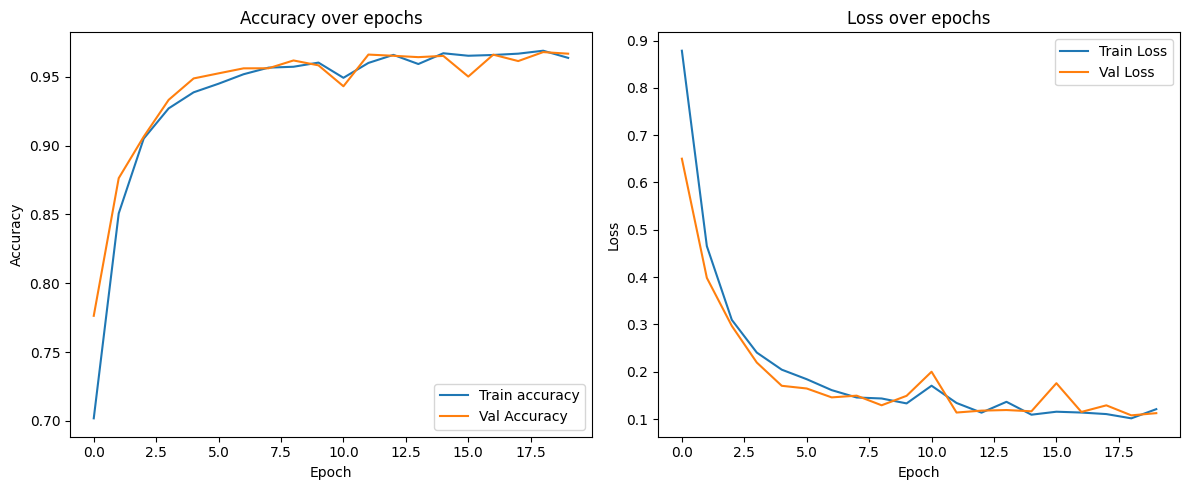

In [21]:
import matplotlib.pyplot as plt

history = unet_model_history.history

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label = 'Train accuracy')
plt.plot(history['val_accuracy'], label = 'Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label = 'Train Loss')
plt.plot(history['val_loss'], label = 'Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()